# Modeling

## Preparation

In [1]:
# Loading Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import sys
from IPython.display import Image
import copy
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as con_mat
from sklearn import metrics
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


import causalnex
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.discretiser.discretiser_strategy import (
    DecisionTreeSupervisedDiscretiserMethod,
)
from causalnex.network import BayesianNetwork
from causalnex.inference import InferenceEngine
import mlflow
import time
import warnings
warnings.filterwarnings("ignore")

c:\Users\IRONMAN\miniconda3\envs\py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from utils import Utils
Util = Utils("../logs/modeling_notebook.logs")

In [3]:
# Loading Dataset

raw_df = pd.read_csv("../data/data.csv")
raw_df = raw_df.iloc[:,1:-1]
raw_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Feature Extraction

In [4]:
# Separating features and target
 
features_df = raw_df.drop('diagnosis',axis=1)
target_df = raw_df['diagnosis']

In [5]:
features_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
target_df

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

INFO:utils:correlatin heatmap successfully generated


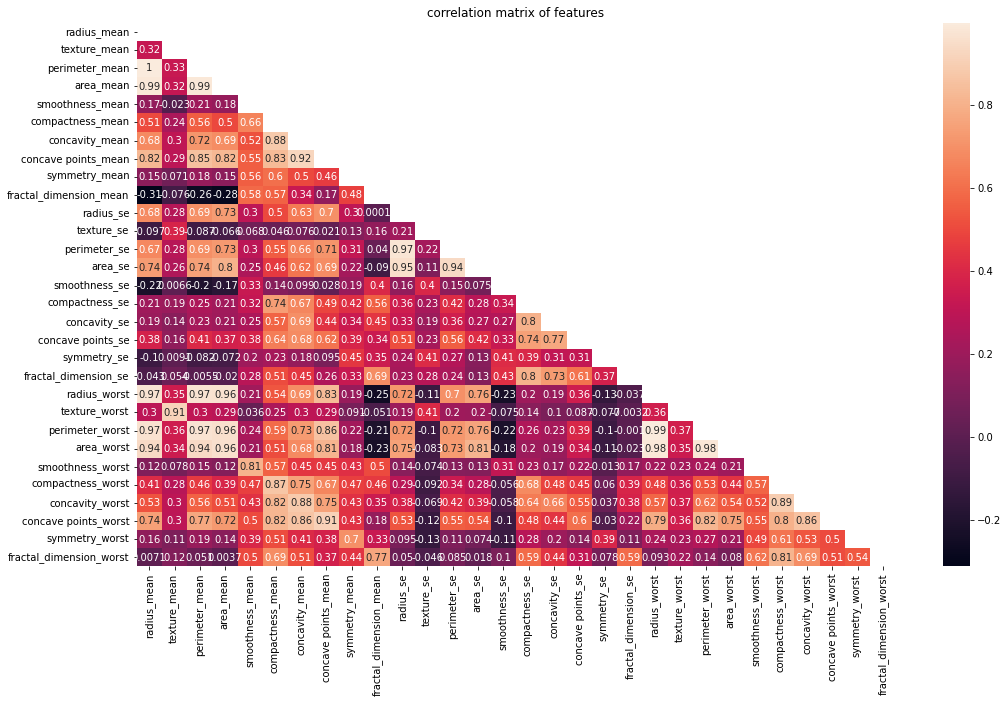

In [7]:
# lets eleminate highly correlated features first
#correlation matrix
Util.show_corr(features_df, "correlation matrix of features", save=True, name="features_correlation.png")

In [8]:
features_df2 = Util.remove_correlated(features_df, 0.9)
features_df2.head()

INFO:utils:correlated variables successfully removed


number of correlated variables: 10
..................................................
correlated features:  {'perimeter_se', 'concave points_mean', 'perimeter_worst', 'area_se', 'area_mean', 'texture_worst', 'area_worst', 'concave points_worst', 'radius_worst', 'perimeter_mean'}


,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,0.11840,0.27760,0.3001,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.4601,0.11890
1,20.57,17.77,0.08474,0.07864,0.0869,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.2750,0.08902
2,19.69,21.25,0.10960,0.15990,0.1974,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.3613,0.08758
3,11.42,20.38,0.14250,0.28390,0.2414,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.6638,0.17300
4,20.29,14.34,0.10030,0.13280,0.1980,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.2364,0.07678


In [9]:
Util.forest_test(features_df2, target_df)

INFO:utils:forest test successful


accuracy score: 0.9590643274853801


In [10]:
selected_feat = Util.select_features_RFE(features_df2, target_df, 10)
selected_feat.head()

INFO:utils:successfully selected features


,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst
0,17.99,10.38,0.11840,0.3001,1.0950,0.04904,0.1622,0.6656,0.7119,0.4601
1,20.57,17.77,0.08474,0.0869,0.5435,0.01308,0.1238,0.1866,0.2416,0.2750
2,19.69,21.25,0.10960,0.1974,0.7456,0.04006,0.1444,0.4245,0.4504,0.3613
3,11.42,20.38,0.14250,0.2414,0.4956,0.07458,0.2098,0.8663,0.6869,0.6638
4,20.29,14.34,0.10030,0.1980,0.7572,0.02461,0.1374,0.2050,0.4000,0.2364


In [11]:
Util.forest_test(selected_feat, target_df)

INFO:utils:forest test successful


accuracy score: 0.9590643274853801


### Observation
- As can be seen from the random forest regression test, the accuracy has decreased only by 1%

### Scaling and Normalization

In [12]:
# scaling and normalizing
scaled = Util.scale_and_normalize(selected_feat)
scaled.head()

INFO:utils:variables scaled successfully
INFO:utils:variables normalized succesfully
INFO:utils:variables successfully scaled and normalized


,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst
0,0.311623,0.013551,0.355113,0.420535,0.213005,0.210165,0.359528,0.370387,0.340075,0.357930
1,0.685209,0.290401,0.308840,0.216925,0.166668,0.086642,0.370285,0.164673,0.205593,0.248868
2,0.448247,0.290830,0.383274,0.344673,0.171119,0.211609,0.360381,0.287189,0.268089,0.300850
3,0.101686,0.174650,0.392688,0.273759,0.067322,0.262922,0.443099,0.393991,0.265549,0.484011
4,0.562838,0.139909,0.384539,0.414532,0.208931,0.150043,0.390805,0.154061,0.285478,0.140734


## Causal Graph Discovery

In [13]:
# rejoin target and features
pure_df = selected_feat.copy()
pure_df["target"] = LabelEncoder().fit_transform(target_df)

# 1 means Malignunt and 0 means Benign 
pure_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,target
0,17.99,10.38,0.11840,0.3001,1.0950,0.04904,0.1622,0.6656,0.7119,0.4601,1
1,20.57,17.77,0.08474,0.0869,0.5435,0.01308,0.1238,0.1866,0.2416,0.2750,1
2,19.69,21.25,0.10960,0.1974,0.7456,0.04006,0.1444,0.4245,0.4504,0.3613,1
3,11.42,20.38,0.14250,0.2414,0.4956,0.07458,0.2098,0.8663,0.6869,0.6638,1
4,20.29,14.34,0.10030,0.1980,0.7572,0.02461,0.1374,0.2050,0.4000,0.2364,1


In [14]:
factor = len(pure_df)/100
pure_20 = pure_df.sample(int(20*factor), random_state=11)
print(f"size of pure_20 : {len(pure_20)}")
pure_40 = pure_df.sample(int(40*factor), random_state=11)
print(f"size of pure_40 : {len(pure_40)}")
pure_60 = pure_df.sample(int(60*factor), random_state=11)
print(f"size of pure_60 : {len(pure_60)}")
pure_80 = pure_df.sample(int(80*factor), random_state=11)
print(f"size of pure_80 : {len(pure_80)}")
print(f"size of pure_100 : {len(pure_df)}")

size of pure_20 : 113
size of pure_40 : 227
size of pure_60 : 341
size of pure_80 : 455
size of pure_100 : 569


In [15]:
# generate the ground truth structure
ground_truth = from_pandas(pure_df, tabu_parent_nodes=["target"])

In [16]:
# generate structures from fractional datasets

sm20 = from_pandas(pure_20, tabu_parent_nodes=["target"])
sm40 = from_pandas(pure_40, tabu_parent_nodes=["target"])
sm60 = from_pandas(pure_60, tabu_parent_nodes=["target"])
sm80 = from_pandas(pure_80, tabu_parent_nodes=["target"])

### Check Stability of Graph

INFO:utils:treshold successfully applied
INFO:utils:graph successfully generated


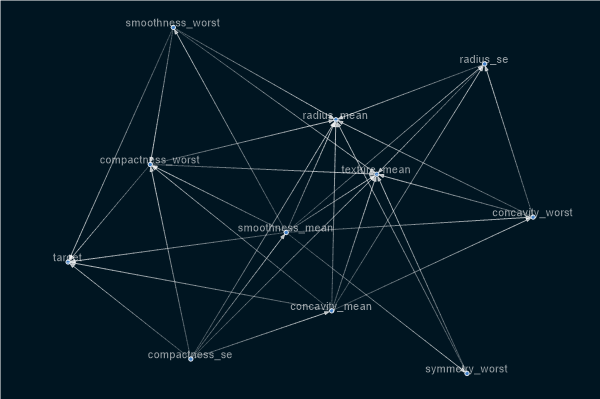

In [17]:
Util.plot_graph(ground_truth, 0.8, True, "groud_truth_graph.png")

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 0.74


INFO:utils:graph successfully generated


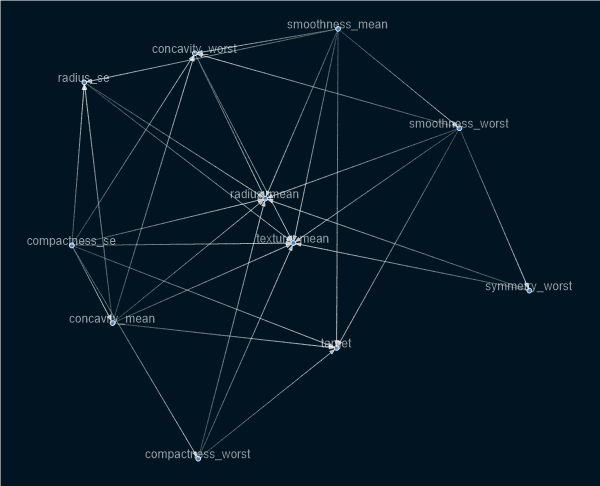

In [18]:
print(Util.jacc_index(ground_truth,sm20, 0.8, 0.8))
Util.plot_graph(sm20, 0.8, True, "sm20_graph.png")

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 0.89


INFO:utils:graph successfully generated


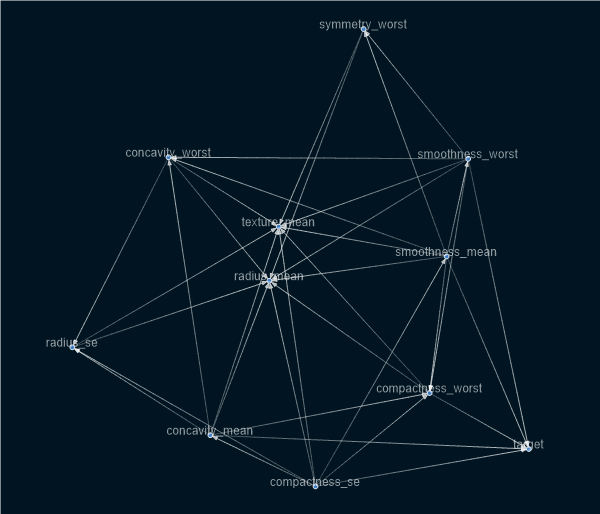

In [19]:
print(Util.jacc_index(ground_truth,sm40, 0.8, 0.8))
Util.plot_graph(sm40, 0.8, True, "sm40_graph.png")

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 0.89


INFO:utils:graph successfully generated


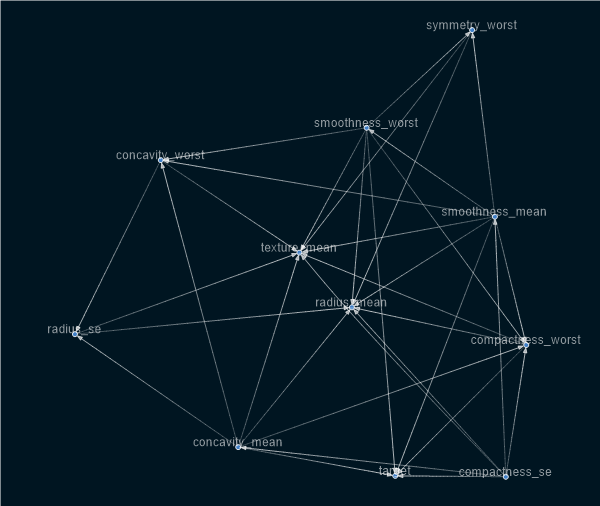

In [20]:
print(Util.jacc_index(ground_truth,sm60, 0.8, 0.8))
Util.plot_graph(sm60, 0.8, True, "sm60_graph.png")

INFO:utils:jaccard index successfully calculated
INFO:utils:treshold successfully applied


The similarity index: 0.92


INFO:utils:graph successfully generated


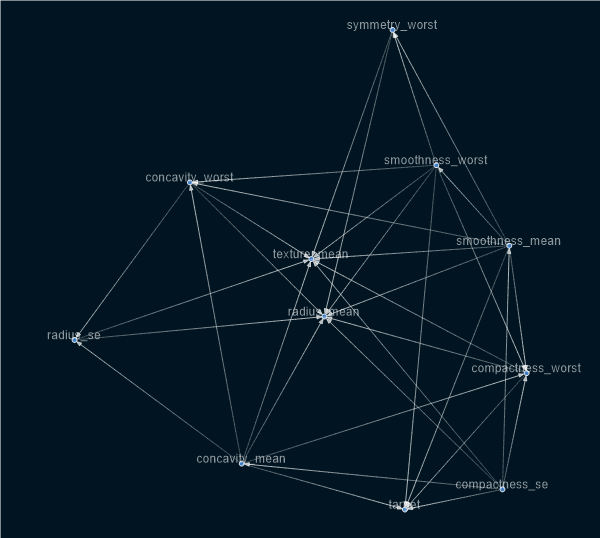

In [21]:
print(Util.jacc_index(ground_truth,sm80, 0.8, 0.8))
Util.plot_graph(sm80, 0.8, True, "sm80_graph.png")

## Modeling

### Preparing Data and Graph

In [22]:
# preparing data for logistic regression modelling
original_x = selected_feat
original_y = target_df.apply(lambda x: 0 if x=="B" else 1)
original_full = original_x.copy()
original_full["target"] = original_y

filtered = Util.filter_by_blanket(Util.apply_treshold(ground_truth, 0.8), original_x, "target")
filtered_x = filtered[0]
filtered_y = original_y
filtered_full = filtered_x.copy()
filtered_full["target"] = filtered_y


# preparing graphs for bayesian network modeling
original_sm = Util.apply_treshold(ground_truth, 0.8)
filtered_sm = filtered[1]

INFO:utils:treshold successfully applied
INFO:utils:blanket successfully extracted
INFO:utils:treshold successfully applied


[('smoothness_worst', 'compactness_worst'), ('smoothness_worst', 'target'), ('concavity_mean', 'compactness_worst'), ('concavity_mean', 'target'), ('smoothness_mean', 'smoothness_worst'), ('smoothness_mean', 'compactness_worst'), ('smoothness_mean', 'target'), ('compactness_worst', 'target'), ('compactness_se', 'smoothness_mean'), ('compactness_se', 'concavity_mean'), ('compactness_se', 'compactness_worst'), ('compactness_se', 'target')]
selected variables: ['smoothness_worst', 'concavity_mean', 'smoothness_mean', 'compactness_worst', 'compactness_se']


### Bayesian Network Modeling

In [23]:

desc_ori_df = Util.data_descretiser(original_full, original_x.columns.to_list(), "target")
desc_filt_df = Util.data_descretiser(filtered_full, filtered_x.columns.to_list(), "target")

INFO:utils:successfully descretised dataframe
INFO:utils:successfully descretised dataframe


In [24]:
# split dataset.
train_o, test_o = train_test_split( desc_ori_df, train_size=0.8, test_size=0.2, random_state=27)
train_f, test_f = train_test_split( desc_filt_df, train_size=0.8, test_size=0.2, random_state=27)

In [25]:
# create Bayesian Network
bn1 = Util.get_bayesian_net(desc_ori_df, train_o, original_sm)
bn2 = Util.get_bayesian_net(desc_filt_df, train_f, filtered_sm)

INFO:utils:bn successfully generated
INFO:utils:bn successfully generated


In [26]:
pred_v1 = bn1.predict(test_o, 'target')
true_v1 = test_o['target']

pred_v2 = bn2.predict(test_f, 'target')
true_v2 = test_f['target']

In [27]:
Util.get_metrics(y_true=true_v1, y_pred=pred_v1)

{'accuracy': 0.88, 'precision': 0.94, 'recall': 0.73, 'f1': 0.82}

In [28]:
Util.get_metrics(y_true=true_v2, y_pred=pred_v2)

{'accuracy': 0.88, 'precision': 0.94, 'recall': 0.73, 'f1': 0.82}

In [29]:
# saving models
joblib.dump(bn1, "../data/models/bayseain_original.pkl")
joblib.dump(bn2, "../data/models/bayseain_selected.pkl")

['../data/models/bayseain_selected.pkl']

### Observation
- as can be seen from the above results the prediction ability of the data is the same
  whether the nodes outside the blanket are included or not 

### Logistic Regression Modeling

#### Model Training

In [30]:
# training with the original dataset

X_train, X_test, y_train, y_test = train_test_split(original_x, original_y, test_size=0.2, random_state=0)
log_model_o = LogisticRegression()
log_model_o.fit(X_train, y_train)

LogisticRegression()

In [31]:
# training with the filtered dataset

X_train2, X_test2, y_train2, y_test2 = train_test_split(filtered_x, filtered_y, test_size=0.2, random_state=0)
log_model_f = LogisticRegression()
log_model_f.fit(X_train2, y_train2)

LogisticRegression()

#### Prediction

In [32]:
y_pred_o = log_model_o.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(log_model_o.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.9298


In [33]:
y_pred_f = log_model_f.predict(X_test2)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(log_model_f.score(X_test2, y_test2)))

Accuracy of logistic regression classifier on test set: 0.7719


In [34]:
# confustion matrix for ogininal dataset

confusion_matrix = con_mat(y_test, y_pred_o)
print(confusion_matrix)

[[63  4]
 [ 4 43]]


This means there were 106 (63+43) correct predictions and 8 (4+4) incorrect predictions 

In [35]:
# confustion matrix for filtered dataset

confusion_matrix = con_mat(y_test2, y_pred_f)
print(confusion_matrix)

[[62  5]
 [21 26]]


This means there were 88 (62+26) correct predictions and 26 (21+5) incorrect predictions

In [36]:
values = Util.get_metrics(y_true=y_test, y_pred=y_pred_o)
Util.mlflow_log("regression_exp", "run_1", values)

# open file for writing
f = open("../data/outputs/output.txt","w")
message = f"metric values for a logistic regression model created using all original features: \n{str(values)}\n\n"
f.write( message )
f.close()

values

Run - run_1 is logged to Experiment - regression_exp


{'accuracy': 0.93, 'precision': 0.91, 'recall': 0.91, 'f1': 0.91}

In [41]:
values2 = Util.get_metrics(y_true=y_test2, y_pred=y_pred_f)
Util.mlflow_log("regression_exp", "run_2", values2)
# open file for writing
f = open("../data/outputs/output.txt","w")
message = f"metric values for a logistic regression model created using filtered features: \n{str(values2)}\n\n"
f.write( message )
f.close()

values2

Run - run_2 is logged to Experiment - regression_exp


{'accuracy': 0.77, 'precision': 0.84, 'recall': 0.55, 'f1': 0.67}

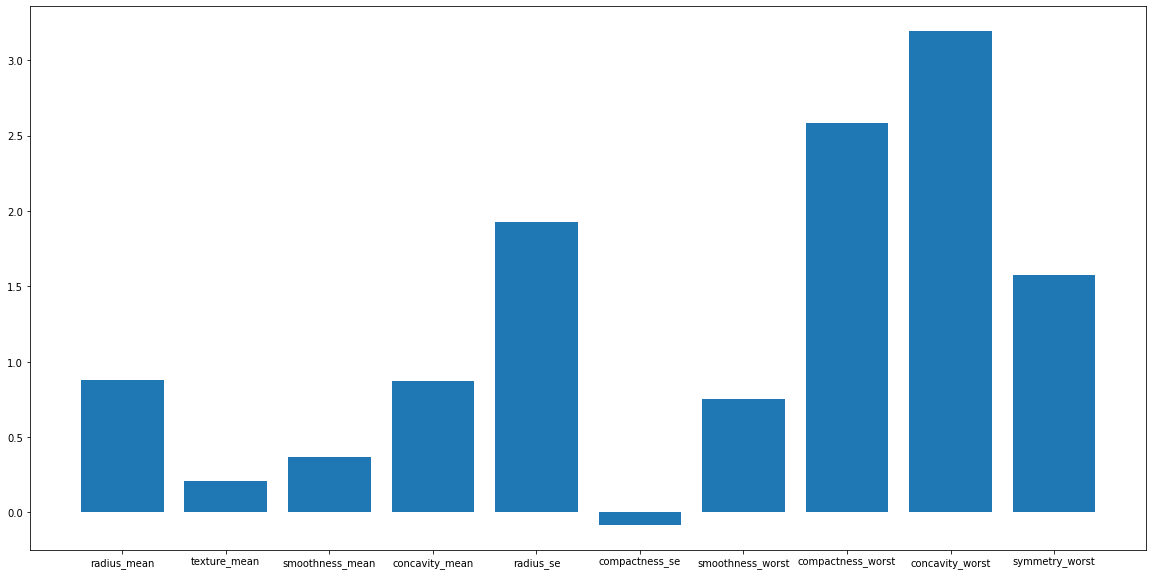

In [38]:
Util.show_importance(log_model_o, original_x.columns.to_list(), [20,10], True, "importance_original.png")

the most important features are concavity worst, compactness_worst, and radius_se

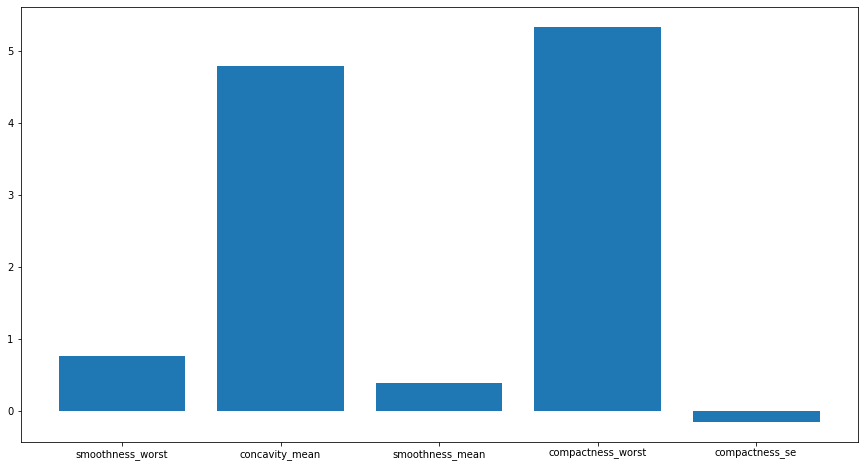

In [39]:
Util.show_importance(log_model_f, filtered_x.columns.to_list(), [15,8], True, "importance_filtered.png")

In [40]:
# Saving models
joblib.dump(log_model_o, "../data/models/log_reg_original.pkl")
joblib.dump(log_model_f, "../data/models/log_reg_filtered.pkl")

['../data/models/log_reg_filtered.pkl']